In [94]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import pmdarima as pm
import os
import seaborn as sns
import skforecast


from lightgbm import LGBMRegressor
from skforecast.model_selection import backtesting_forecaster
from skforecast.recursive import ForecasterRecursive
# TODO: Check which of the following get used once notebook is finalized,
# gid rid of rest
from skforecast.model_selection import backtesting_forecaster, bayesian_search_forecaster, grid_search_forecaster, TimeSeriesFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.tree import DecisionTreeRegressor
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
# Reading in data from local machine
# Datasource (open, publicly available):
# https://opendata.cityofnewyork.us/
# TODO: In GitHub so should be cloned, but we should 
# skip putting the data together with code and have 
# a finished dataframe that people can work with
nyc_path = os.getcwd() + '/raw_data/attendance'

In [58]:
# Assembling the data .csv by .csv
csv_files = glob.glob(nyc_path + "/*.csv")
  
# Empty list for storing data
temp_dfs = []
# loop over the list of csv files 
for f in csv_files:    
    # read the csv file 
    df = pd.read_csv(f)
    if "School DBN" in df.columns:
        df = df.rename(columns={"School DBN": "School"})
    if type(df['Date'][0]) != 'str':
        df['Date'] = df['Date'].astype('str')
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=False, format='mixed')

    temp_dfs.append(df)
attendance_data = pd.concat(temp_dfs)

In [59]:
# Look at the columns
attendance_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3269131 entries, 0 to 736577
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   School      object        
 1   Date        datetime64[ns]
 2   SchoolYear  int64         
 3   Enrolled    float64       
 4   Present     float64       
 5   Absent      float64       
 6   Released    float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 199.5+ MB


In [60]:
# How many unique school IDs do we have?
attendance_data['School'].nunique()

1795

In [61]:
# Let's look at a frequency table for School values
attendance_data['School'].value_counts()

School
15K592    2184
75K053    2088
75M138    2088
75M094    2088
75K811    2088
          ... 
79M331     162
03M577     131
79K657     123
03M865      40
10X435      20
Name: count, Length: 1795, dtype: int64

In [62]:
# Store two school IDs to limit the data to one school at a time
school_id_to_use = '15K592'
school_id_to_use_2 = '01M015'

In [63]:
# Creating dataframes limited to one school
data_1_school = attendance_data.loc[attendance_data['School'] == school_id_to_use].sort_values('Date')
data_2_school = attendance_data.loc[attendance_data['School'] == school_id_to_use_2].sort_values('Date')

<Axes: xlabel='Date', ylabel='Count'>

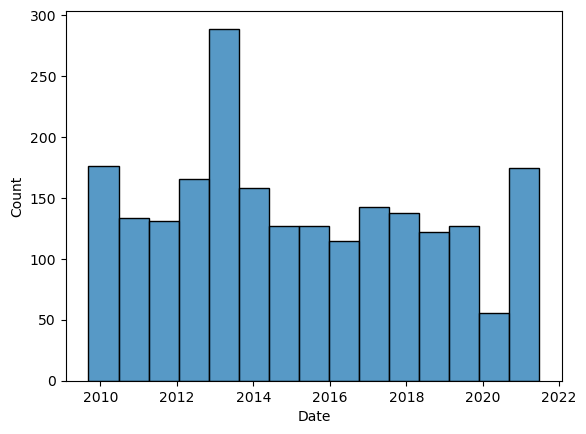

In [64]:
# Look at histogram giving dates for first school
# Notice the high count for circa 2013
# Other data explorations showed a lot of
# duplicates by date for this school for some
# reason, will drop duplicates by date later
sns.histplot(data=data_1_school, x='Date')

<Axes: xlabel='Date', ylabel='Absent'>

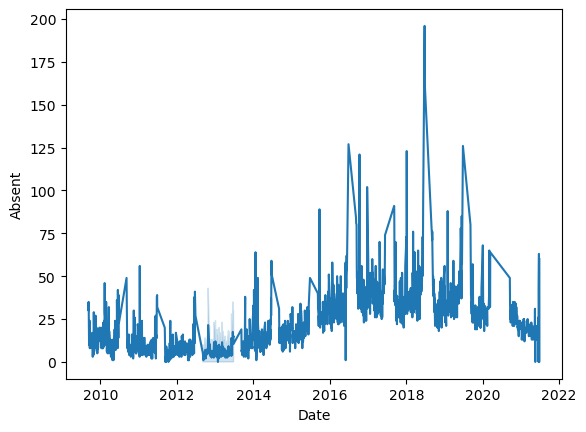

In [65]:
# What does the count of absences look like across time for first school?
sns.lineplot(data=data_1_school, x='Date', y='Absent')

<Axes: xlabel='Date', ylabel='Absent'>

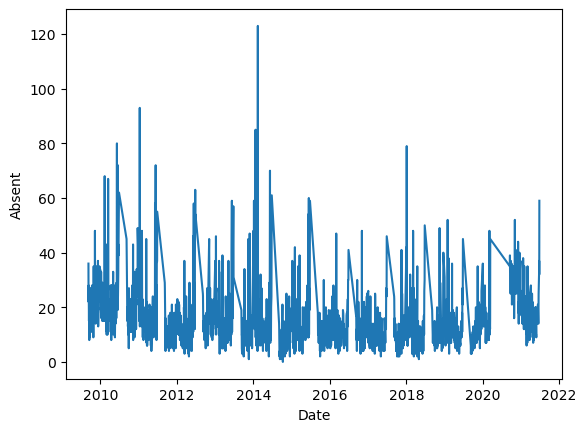

In [66]:
# Same for second schools
sns.lineplot(data=data_2_school, x='Date', y='Absent')

In [67]:
# Create an absence rate that adjusts for enrollment for both schools
data_1_school['absence_rate'] = data_1_school['Absent']/data_1_school['Enrolled']
data_2_school['absence_rate'] = data_2_school['Absent']/data_2_school['Enrolled']

In [68]:
# Let's get descriptives on absence_rate
data_1_school[['absence_rate', 'Absent']].describe()

,absence_rate,Absent
count,2184.000000,2184.000000
mean,0.120017,20.455128
std,0.076248,16.757159
min,0.000000,0.000000
25%,0.078873,8.000000
50%,0.116204,17.000000
75%,0.151030,30.000000
max,0.720588,196.000000


In [69]:
# Look at first few rows of data with absence_rate
data_1_school.head()

,School,Date,SchoolYear,Enrolled,Present,Absent,Released,absence_rate
415948,15K592,2009-09-09,20092010,129.0,95.0,34.0,0.0,0.263566
415949,15K592,2009-09-10,20092010,130.0,100.0,30.0,0.0,0.230769
415950,15K592,2009-09-11,20092010,130.0,95.0,35.0,0.0,0.269231
415951,15K592,2009-09-14,20092010,127.0,112.0,15.0,0.0,0.118110
415952,15K592,2009-09-15,20092010,124.0,114.0,10.0,0.0,0.080645


<Axes: xlabel='Date', ylabel='Count'>

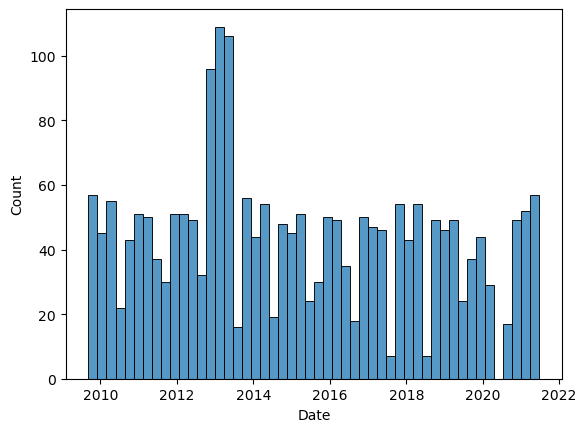

In [70]:
# This shows in more detail what we were seeing before,
# with a suspiciously large number of dates circa 2013
sns.histplot(data=data_1_school, x='Date', bins = 50)

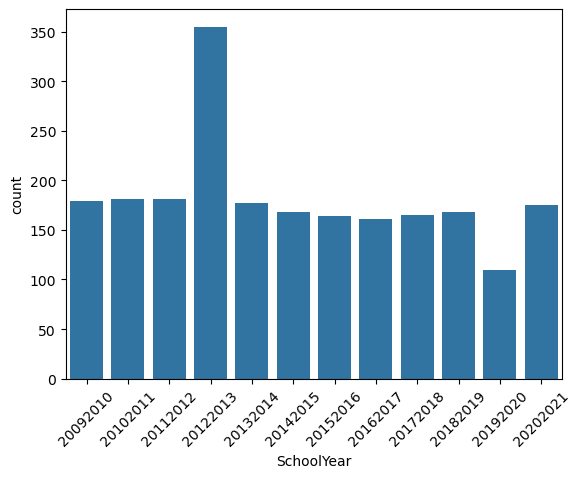

In [71]:
# Let's take another look, this time by school year
# We see roughly twice as many rows of data for 20122013
# compared to other years
g = sns.countplot(data=data_1_school, x='SchoolYear')
g.tick_params(axis='x', labelrotation=45)

In [72]:
# How many unique dates for first school for 20122013?
print(data_1_school.loc[data_1_school.SchoolYear==20122013]['Date'].nunique())
# How many rows of data for the same school year?
len(data_1_school.loc[data_1_school.SchoolYear==20122013])
# That's a big discrepancy, will deduplicate

178


355

In [73]:
# But first let's check if second school has the same issue
print(data_2_school.loc[data_2_school.SchoolYear==20122013]['Date'].nunique())
print(len(data_2_school.loc[data_2_school.SchoolYear==20122013]))
# No such discrepancy, not a data issue that is present for every school...

178
178


In [74]:
# Let's check one more thing: Are there duplicates in prior school year?
print(data_1_school.loc[data_1_school.SchoolYear==20112012]['Date'].nunique())
print(len(data_1_school.loc[data_1_school.SchoolYear==20112012]))
# Numbers match, no duplicates for first school for 20112012 school year...

181
181


<Axes: xlabel='Date', ylabel='absence_rate'>

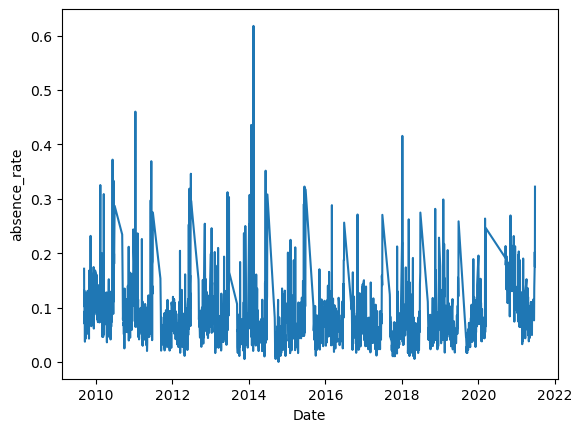

In [75]:
# Let's look at absence rate for second school
sns.lineplot(data=data_2_school, x='Date', y='absence_rate')
# Looks very similar to the plot for second school for Absent
# So enrollment may not be shifting enough for the absence_rate
# to pick up something different than Absence. Still, it's a metric
# we can more easily interpret (e.g., > 60% of enrolled students were
# absent at the beginning of 2014), so let's use absence_rate for
# our models

In [76]:
# Deduplicating by date for first school
data_1_school_no_dups = data_1_school.drop_duplicates('Date')

In [77]:
# Let's get the data ready for analyses
tscv = TimeSeriesSplit(n_splits=2, test_size=180)
data_2_school_for_ts = data_2_school.copy()

In [78]:
data_2_school_for_ts.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2083 entries, 0 to 456344
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   School        2083 non-null   object        
 1   Date          2083 non-null   datetime64[ns]
 2   SchoolYear    2083 non-null   int64         
 3   Enrolled      2083 non-null   float64       
 4   Present       2083 non-null   float64       
 5   Absent        2083 non-null   float64       
 6   Released      2083 non-null   float64       
 7   absence_rate  2083 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 146.5+ KB


In [79]:
data_2_school_for_ts.head()

,School,Date,SchoolYear,Enrolled,Present,Absent,Released,absence_rate
0,01M015,2009-09-09,20092010,210.0,174.0,36.0,0.0,0.171429
1,01M015,2009-09-10,20092010,215.0,193.0,22.0,0.0,0.102326
2,01M015,2009-09-11,20092010,213.0,185.0,28.0,0.0,0.131455
3,01M015,2009-09-14,20092010,214.0,199.0,15.0,0.0,0.070093
4,01M015,2009-09-15,20092010,214.0,194.0,20.0,0.0,0.093458


In [80]:
# Getting together the "split" data
# TimeSeriesSplit includes 1723:1902 as the test data in the first fold
# and 109:2082 as the test data in the second fold
# Therefore we can use data from the first fold to get our model up and running
# and then once we are happy with our model for that dataframe, do a final check
# of how it runs on  the dataframe from the second fold (keeping in mind that the
# second fold will include data from fall 2020 --> a challenging "test" of our model!
train_test_indices = {}
for i, (train_index, test_index) in enumerate(tscv.split(data_2_school_for_ts.index.values)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}")
    print(f"  Test:  index={test_index}")
    train_test_indices[f"train_fold_{i}"] = train_index
    train_test_indices[f"test_fold_{i}"] = test_index

Fold 0:
  Train: index=[   0    1    2 ... 1720 1721 1722]
  Test:  index=[1723 1724 1725 1726 1727 1728 1729 1730 1731 1732 1733 1734 1735 1736
 1737 1738 1739 1740 1741 1742 1743 1744 1745 1746 1747 1748 1749 1750
 1751 1752 1753 1754 1755 1756 1757 1758 1759 1760 1761 1762 1763 1764
 1765 1766 1767 1768 1769 1770 1771 1772 1773 1774 1775 1776 1777 1778
 1779 1780 1781 1782 1783 1784 1785 1786 1787 1788 1789 1790 1791 1792
 1793 1794 1795 1796 1797 1798 1799 1800 1801 1802 1803 1804 1805 1806
 1807 1808 1809 1810 1811 1812 1813 1814 1815 1816 1817 1818 1819 1820
 1821 1822 1823 1824 1825 1826 1827 1828 1829 1830 1831 1832 1833 1834
 1835 1836 1837 1838 1839 1840 1841 1842 1843 1844 1845 1846 1847 1848
 1849 1850 1851 1852 1853 1854 1855 1856 1857 1858 1859 1860 1861 1862
 1863 1864 1865 1866 1867 1868 1869 1870 1871 1872 1873 1874 1875 1876
 1877 1878 1879 1880 1881 1882 1883 1884 1885 1886 1887 1888 1889 1890
 1891 1892 1893 1894 1895 1896 1897 1898 1899 1900 1901 1902]
Fold 1:
  Tr

In [81]:
# This part is very "Python-y" and may be confusing for people who are new to Python
# The TrainTestSplit that we ran above created two dataframes, each with two different
# splits of the data
# My loop named the first dataframe train_test_indices['train_fold_0'], and the [0]
# I added at the end tells Python we only want the first "split" (the training data)
# Similarly, we can use train_test_indices['train_fold_0'][-1] to get the last (of 2)
# splits. If you've used indices in R (e.g., `df[3,]` to get just the third row of an
# R dataset named df), the idea is similar here. But what is different is that indices
# in Python start with 0, and if you are unsure or don't know what the last index is,
# you can use the index -1, which will give you the last (and -2 will give you the second
# to last, etc.)
train_start = data_2_school_for_ts.iloc[train_test_indices['train_fold_0'][0]]['Date']
train_end = data_2_school_for_ts.iloc[train_test_indices['train_fold_0'][-1]]['Date']

test_start = data_2_school_for_ts.iloc[train_test_indices['test_fold_0'][0]]['Date']
test_end = data_2_school_for_ts.iloc[train_test_indices["test_fold_0"][-1]]['Date']

In [82]:
# Let's check on the start and end dates
print(train_start)
print(train_end)
print(test_start)
print(test_end)

2009-09-09 00:00:00
2019-03-06 00:00:00
2019-03-07 00:00:00
2020-03-06 00:00:00


In [83]:
data_2_school_for_ts.set_index('Date', inplace = True)

In [84]:
data_2_school_for_ts.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2083 entries, 2009-09-09 to 2021-06-25
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   School        2083 non-null   object 
 1   SchoolYear    2083 non-null   int64  
 2   Enrolled      2083 non-null   float64
 3   Present       2083 non-null   float64
 4   Absent        2083 non-null   float64
 5   Released      2083 non-null   float64
 6   absence_rate  2083 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 130.2+ KB


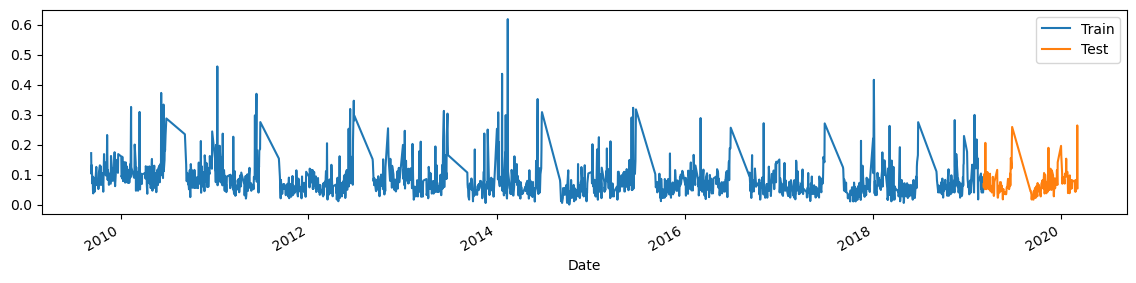

In [85]:
fig, ax = plt.subplots(figsize=(14, 3))
data_2_school_for_ts['absence_rate'].loc[train_start:train_end].plot(ax=ax, label = "Train")
data_2_school_for_ts['absence_rate'].loc[test_start: test_end].plot(ax=ax, label = "Test")
ax.legend()

In [118]:
# TODO: Fix warning; warning about indices may also help with using TimeSeriesFold in skforecaster
# I consulted this source: https://medium.com/@mouse3mic3/a-practical-guide-on-scikit-learn-for-time-series-forecasting-bbd15b611a5d
# But there were issues with this one initially (see legacy code for ForecasterRecursive and LGBMRegressor, not sure of source)
# And the above source does not appear to give all needed import statements

# Set the values for the index for the predictions, based
# on start and end dates for test that are actually in the
# data
dates_for_preds = data_2_school_for_ts.loc[test_start: test_end].index.values
# Define the forecaster
forecaster_tree=ForecasterRecursive(
    # Add the sklearn regressor and lags
    regressor=DecisionTreeRegressor(random_state=123),
    lags=20
)
# Define the forecaster
forecaster_lgbmr=ForecasterRecursive(
    # Add the sklearn regressor and lags
    regressor=LGBMRegressor(random_state=123, verbose=-1),
    lags=20
)

# Store the model algorithms in a list for looping
model_algs = [forecaster_tree, forecaster_lgbmr]
# Store a name for each model algorithm, also for looping
model_names = ['tree', 'lgbmr']
# Create an empty map for storing the data, the root mean square error
reg_model_preds = {}
reg_model_rmses = {}
# Fit the models using train data
for model_alg, model_name in zip(model_algs, model_names):
    # 
    model_alg.fit(y = data_2_school_for_ts['absence_rate'].loc[train_start:train_end])

    # Predict the test period
    predicted_test = model_alg.predict(steps = len(data_2_school_for_ts['absence_rate'].loc[test_start:test_end]))
    predicted_test = pd.DataFrame(predicted_test)
    predicted_test['Date'] = dates_for_preds
    predicted_test.set_index('Date', inplace = True)

    # Get RMSE
    rmse_test = np.sqrt(mean_squared_error(data_2_school_for_ts['absence_rate'].loc[test_start:test_end], predicted_test))
    print(f'RMSE for {model_name}')
    print('RMSE Test:', rmse_test)

    # Store results in reg_model_results, with model specified
    reg_model_preds[model_name] = predicted_test
    reg_model_rmses[model_name] = rmse_test

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has a pandas DatetimeIndex without a frequency. The index will be replaced by │
│ a RangeIndex starting from 0 with a step of 1. To avoid this warning, set the        │
│ frequency of the DatetimeIndex using `y = y.asfreq('desired_frequency',              │
│ fill_value=np.nan)`.                                                                 │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\skforecast\utils\utils.py │
│ :1411                                                                                │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `last_window` has a pandas DatetimeIndex without a frequency. The index will be      │
│ replaced by a RangeIndex starting from 0 with a step of 1. To avoid this warning,    │
│ set the frequency of the DatetimeIndex using `last_window =                          │
│ last_window.asfreq('desired_frequency', fill_value=np.nan)`.                         │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\skforecast\utils\utils.py │
│ :1455                                                                                │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

RMSE for tree
RMSE Test: 0.17383305957125122


╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ Series has a pandas DatetimeIndex without a frequency. The index will be replaced by │
│ a RangeIndex starting from 0 with a step of 1. To avoid this warning, set the        │
│ frequency of the DatetimeIndex using `y = y.asfreq('desired_frequency',              │
│ fill_value=np.nan)`.                                                                 │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\skforecast\utils\utils.py │
│ :1411                                                                                │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

╭──────────────────────────────────── IndexWarning ────────────────────────────────────╮
│ `last_window` has a pandas DatetimeIndex without a frequency. The index will be      │
│ replaced by a RangeIndex starting from 0 with a step of 1. To avoid this warning,    │
│ set the frequency of the DatetimeIndex using `last_window =                          │
│ last_window.asfreq('desired_frequency', fill_value=np.nan)`.                         │
│                                                                                      │
│ Category : IndexWarning                                                              │
│ Location :                                                                           │
│ C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\skforecast\utils\utils.py │
│ :1455                                                                                │
│ Suppress : warnings.simplefilter('ignore', category=IndexWarning)                    │
╰──────────────────────────────────────────────────────────────────────────────────────╯

RMSE for lgbmr
RMSE Test: 0.07893585132004702


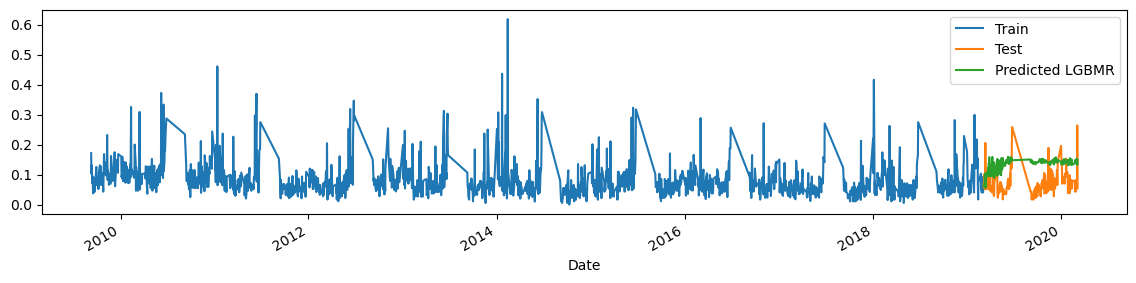

In [87]:
fig, ax = plt.subplots(figsize=(14, 3))
data_2_school_for_ts['absence_rate'].loc[train_start:train_end].plot(ax=ax, label = "Train")
data_2_school_for_ts['absence_rate'].loc[test_start:test_end].plot(ax=ax, label = "Test")
reg_model_preds['lgbmr']['pred'].plot(ax=ax, label = "Predicted LGBMR")
ax.legend()

In [88]:
# TODO: Fix warnings!
# TODO: Incorporate into loop?
arima = pm.AutoARIMA(seasonal = True)
arima.fit(data_2_school_for_ts['absence_rate'].loc[train_start:train_end])

# Predict train and test
arima_train = arima.predict_in_sample()
arima_test = arima.predict(len(data_2_school_for_ts['absence_rate'].loc[test_start:test_end]))
arima_test = pd.DataFrame(arima_test, columns=['pred'])
arima_test = arima_test.set_index(dates_for_preds)

arima_rmse_train = np.sqrt(mean_squared_error(data_2_school_for_ts['absence_rate'].loc[train_start:train_end], arima_train))
arima_rmse_test = np.sqrt(mean_squared_error(data_2_school_for_ts['absence_rate'].loc[test_start:test_end], arima_test))
print('ARIMA RMSE Train:', arima_rmse_train,'\nARIMA RMSE Test:', arima_rmse_test)

C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'e

ARIMA RMSE Train: 0.05061004877462674 
ARIMA RMSE Test: 0.04074518357742449


C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\tchia\anaconda3\envs\zero_to_ai\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [89]:
# Source on parameters for ARIMA
# https://alkaline-ml.com/pmdarima/tips_and_tricks.html

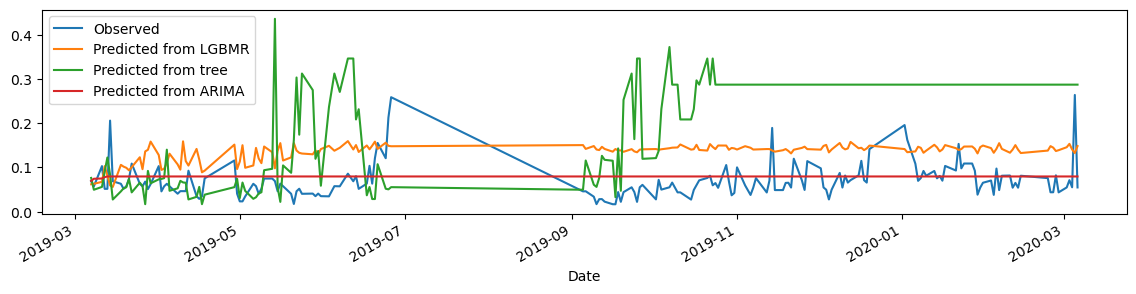

In [90]:
fig, ax = plt.subplots(figsize=(14, 3))
data_2_school_for_ts['absence_rate'].loc[test_start:test_end].plot(ax=ax, label = "Observed")
reg_model_preds['lgbmr']['pred'].plot(ax=ax, label="Predicted from LGBMR")
reg_model_preds['tree']['pred'].plot(ax=ax, label="Predicted from tree")
arima_test['pred'].plot(ax=ax, label="Predicted from ARIMA")
ax.legend()

In [91]:
# Add backtesting for LGBM Regressor (backtesting_forecaster)
# See this source: https://cienciadedatos.net/documentos/py58-forecasting-time-series-with-lightgbm.html

In [120]:
# Hyperparameter tuning for most promising model: light gradient boosting machine regressor
# Code inspired by this source:
# https://skforecast.org/0.15.0/user_guides/hyperparameter-tuning-and-lags-selection.html
# Also see this source: https://cienciadedatos.net/documentos/py58-forecasting-time-series-with-lightgbm.html

# Lags used as predictors
lags_grid = {
    'lags_1': 3,
    'lags_2': 10,
    'lags_3': [1, 2, 3, 20]
}

# Regressor hyperparameters
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 15]
}

# Folds
cv = TimeSeriesFold(
         steps              = 12,
         initial_train_size = len(data_2_school_for_ts['absence_rate'].loc[train_start:train_end]),
         refit              = False
     )

results = grid_search_forecaster(
              forecaster    = forecaster_lgbmr,
              y             = data_2_school_for_ts['absence_rate'].loc[train_start:test_end].reset_index(drop=True),
              param_grid    = param_grid,
              lags_grid     = lags_grid,
              cv            = cv,
              metric        = 'mean_squared_error',
              return_best   = True,
              n_jobs        = 'auto',
              verbose       = False,
              show_progress = True
          )
results

lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3] 
  Parameters: {'max_depth': 5, 'n_estimators': 50}
  Backtesting metric: 0.0017689823317217275
Light GRM regressor best root mean square error:  0.042059271649919565
Light GRM regressor WORST root mean square error:  0.05093402277072816


In [128]:
# Get predictions from tuned LGBMR forecaster
# We can do this because above we had return_best = True
# That means that grid_search_forecaster updated our forecaster_lgbmr model
# to have the tuned (best) hyperparameters
# So when we run `forecaster_lgbmr.predict` below, we are getting predictions
# using the tuned LGBMR model
predicted_test_tuned_lgbmr = forecaster_lgbmr.predict(steps = len(data_2_school_for_ts['absence_rate'].loc[test_start:test_end]))
predicted_test_tuned_lgbmr = pd.DataFrame(predicted_test_tuned_lgbmr)
predicted_test_tuned_lgbmr['Date'] = dates_for_preds
predicted_test_tuned_lgbmr.set_index('Date', inplace = True)

# Get RMSE from tuned LGBMR forecaster
rmse_tuned_lgbmr = np.sqrt(mean_squared_error(data_2_school_for_ts['absence_rate'].loc[test_start:test_end], predicted_test_tuned_lgbmr['pred']))

# Print RMSE, original and tuned
print(f"Light GRM regressor best root mean square error:  {rmse_tuned_lgbmr}")
print(f"Light GRM regressor untuned (original) root mean square error:  {reg_model_rmses['lgbmr']}")

Light GRM regressor best root mean square error:  0.06384729598807931
Light GRM regressor untuned (original) root mean square error:  0.07893585132004702


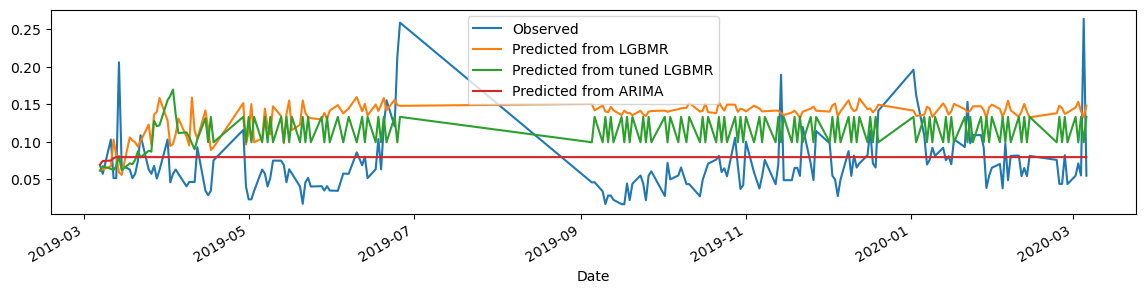

In [111]:
# Add data viz like the above but for "most likely" algorithms
# Point is (at least in part) to show that backfitting and hyperparameter tuning helped
fig, ax = plt.subplots(figsize=(14, 3))
data_2_school_for_ts['absence_rate'].loc[test_start:test_end].plot(ax=ax, label = "Observed")
reg_model_preds['lgbmr']['pred'].plot(ax=ax, label="Predicted from LGBMR")
predicted_test_tuned_lgbmr['pred'].plot(ax=ax, label="Predicted from tuned LGBMR")
arima_test['pred'].plot(ax=ax, label="Predicted from ARIMA")
ax.legend()

The green line above showing the predicted values from the tuned LGBMR model shows a clear improvement over the original (untuned, default) LGBMR model. However, its predictions are still too high much of the time. The predictions from our auto-ARIMA model don't follow the peaks and valleys nearly as well, but do you think that model is doing better overall? Look back at the root mean squared error from the auto-ARIMA model to answer.